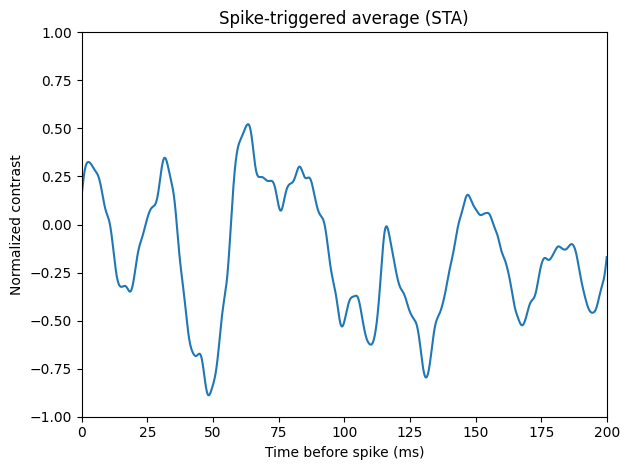

In [1]:
from Neitz import Neitz
from pathlib import Path

# assuming Neitz class is defined above (with:
# - abfread()
# - find_spikes()
# - find_stim_on_off_by_first_rise_and_pause()
# - load_csv()
# - align_contrast()
# - compute_sta()
# - plot_sta()


if __name__ == "__main__":
    n = Neitz(
        filepath=Path.cwd(),       # or Path("C:/path/to/experiment/folder")
        sweep=0,
        spike_ch_num=0,
        stim_ch_num=2,
        peak_height=20.0,
        stim_threshold=0.03,       # threshold in the *0–100 normalized* stim units you plotted
        sta_win_s=0.2,
        t_omit_on=1.0,
        csv_path=Path.cwd() / "data" / "achromatic_gaussian_120s_60Hz_seed1234_20260204_160729.csv",
    )

    # 1) load ABF channels
    n.abfread("2026_02_04_0005.abf")

    # 2) find spikes
    n.find_spikes()

    # 3) find stim onset/offset:
    #    - onset = first rising edge
    #    - offset = falling edge after last pulse before a long pause
    n.find_stim_on_off_by_first_rise_and_pause(
        thr=0.02,
        active_high=False,   # IMPORTANT for your “mostly-high with dips” stim
        long_pause_s=0.5,
        search_from_s=2.0
    )


    # 4) load CSV (new format with time_s + contrast)
    n.load_csv("achromatic_gaussian_120s_60Hz_seed1234_20260204_160729.csv")

    # 5) align per-frame contrast onto ABF time vector using t_on + time_s
    n.align_contrast()

    # 6) compute STA (spike-triggered average of contrast)
    n.compute_sta()

    # 7) plot STA (time-before-spike axis in ms)
    n.plot_sta()


t_on (s): 2.07195
t_off (s): 122.07194999999969
frames in CSV: 7200
spikes inserted: 3656
spikes found by find_peaks: 3656
STA NaN?: False


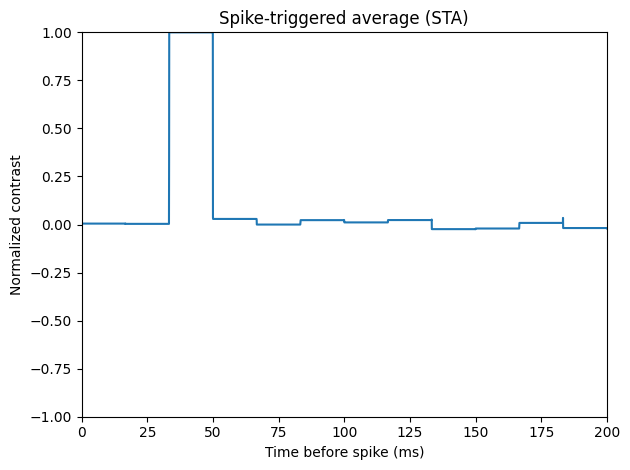

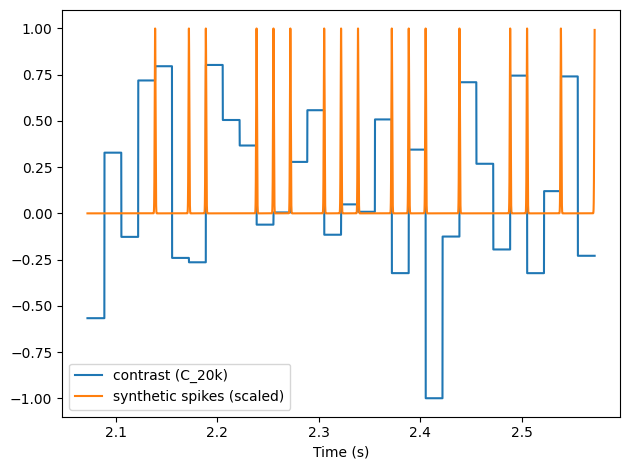

In [5]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from Neitz import Neitz


def make_spike_train(time_vec, spike_times_s, fs, amp=100.0, width_ms=0.4):
    """
    Build a synthetic spike channel with Gaussian-shaped spikes at spike_times_s.
    amp is peak height. width_ms controls Gaussian sigma in ms (smaller = sharper).
    """
    n = len(time_vec)
    x = np.zeros(n, dtype=float)

    # convert spike times to indices
    idx = np.searchsorted(time_vec, spike_times_s)
    idx = idx[(idx > 0) & (idx < n - 1)]  # keep in bounds

    # impulses
    x[idx] = amp

    # gaussian kernel (max=1 so peak stays ~amp after convolution)
    sigma_samp = max(1.0, (width_ms / 1000.0) * fs)
    radius = int(np.ceil(4 * sigma_samp))
    k = np.arange(-radius, radius + 1)
    g = np.exp(-0.5 * (k / sigma_samp) ** 2)
    g = g / g.max()

    y = np.convolve(x, g, mode="same")
    return y, idx


if __name__ == "__main__":
    abf_name = "2026_02_04_0005.abf"
    csv_name = "achromatic_gaussian_120s_60Hz_seed1234_20260204_160729.csv"

    # --- CONFIG: what counts as an "on frame" for this test ---
    # Options:
    #   "all"  -> spike after EVERY frame
    #   "pos"  -> spike only after frames with contrast > 0
    #   "neg"  -> spike only after frames with contrast < 0
    #   "even" -> every other frame (0,2,4,...)  (useful if you think it's effectively 30 Hz)
    ON_MODE = "pos"

    LATENCY_S = 0.050      # 10 ms after frame time
    PEAK_HEIGHT = 20.0     # for find_peaks on synthetic spike channel
    SPIKE_AMP = 100.0
    SPIKE_WIDTH_MS = 0.4

    # --- Load data ---
    n = Neitz(
        filepath=Path.cwd(),
        sweep=0,
        spike_ch_num=0,
        stim_ch_num=2,
        peak_height=PEAK_HEIGHT,
        sta_win_s=0.2,
        t_omit_on=0.0,  # set 0 for this validation so you don't throw away early frames
        csv_path=Path.cwd() / "data" / csv_name,
    )

    n.abfread(abf_name)

    # Use your stim pulse train only to find absolute t_on (start of stimulus epoch)
    # (pulses are LOW dips in your waveform -> active_high=False)
    n.find_stim_on_off_by_first_rise_and_pause(
        thr=0.02,
        active_high=False,
        long_pause_s=0.5,
        search_from_s=2.0,
    )

    # Load CSV (frame times are relative to onset)
    n.load_csv(csv_name)

    # Build "frame on" times in ABF absolute time
    frame_times_abs = n.t_on + n.t_rel_60

    # Select which frames get a spike
    if ON_MODE == "all":
        mask = np.ones_like(n.C_60, dtype=bool)
    elif ON_MODE == "pos":
        mask = n.C_60 > 0
    elif ON_MODE == "neg":
        mask = n.C_60 < 0
    elif ON_MODE == "even":
        mask = (np.arange(len(n.t_rel_60)) % 2) == 0
    else:
        raise ValueError("ON_MODE must be one of: all, pos, neg, even")

    spike_times = frame_times_abs[mask] + LATENCY_S

    # Optional: define t_off from the CSV duration for this test (more deterministic)
    frame_dt = float(np.median(np.diff(n.t_rel_60)))  # ~1/60
    n.t_off = float(n.t_on + n.t_rel_60.max() + frame_dt)

    # Align contrast onto ABF time base (uses n.t_on and CSV)
    n.align_contrast()

    # --- Overwrite spike channel with synthetic spikes ---
    spike_ch_synth, spike_idx = make_spike_train(
        n.time_vec, spike_times, fs=n.fs, amp=SPIKE_AMP, width_ms=SPIKE_WIDTH_MS
    )
    n.spike_ch = spike_ch_synth

    # Run peak finder + STA
    n.find_spikes()

    print("t_on (s):", n.t_on)
    print("t_off (s):", n.t_off)
    print("frames in CSV:", len(n.t_rel_60))
    print("spikes inserted:", len(spike_idx))
    print("spikes found by find_peaks:", len(n.peaks))

    sta = n.compute_sta()
    print("STA NaN?:", bool(np.all(np.isnan(sta))))

    # Plot STA (unsmoothed, so you can see if logic is right)
    n.plot_sta(smooth_ms=0.0)

    # --- Quick sanity plot: first ~0.5 s after onset ---
    t0 = n.t_on
    t1 = n.t_on + 0.5
    i0 = int(np.searchsorted(n.time_vec, t0))
    i1 = int(np.searchsorted(n.time_vec, t1))

    plt.figure()
    plt.plot(n.time_vec[i0:i1], n.C_20k[i0:i1], label="contrast (C_20k)")
    plt.plot(n.time_vec[i0:i1], n.spike_ch[i0:i1] / SPIKE_AMP, label="synthetic spikes (scaled)")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()


2026_02_04_0005.abf: spikes found=19786  spikes used=16212
2026_02_04_0006.abf: spikes found=19565  spikes used=15056
2026_02_04_0007.abf: spikes found=20344  spikes used=16085
2026_02_04_0008.abf: spikes found=21239  spikes used=16270
2026_02_04_0009.abf: spikes found=24536  spikes used=19361


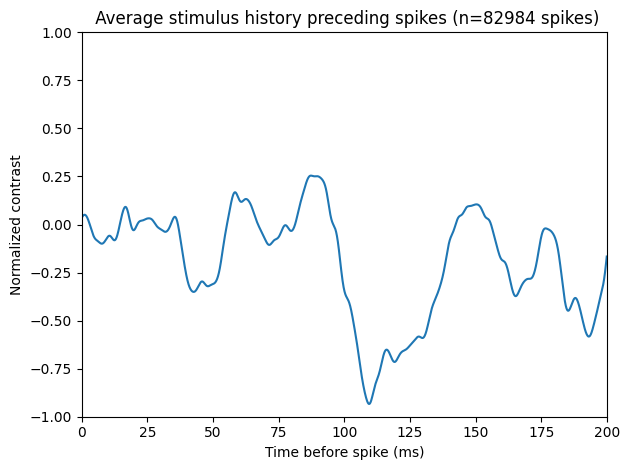

In [9]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from Neitz import Neitz


if __name__ == "__main__":
    csv_name = "achromatic_gaussian_120s_60Hz_seed1234_20260204_160729.csv"
    abf_files = [f"2026_02_04_{i:04d}.abf" for i in range(5, 10)]  # 0005..0009

    # shared params
    STA_WIN_S = 0.2
    T_OMIT_ON = 1.0

    THR = 0.02
    ACTIVE_HIGH = False
    LONG_PAUSE_S = 0.5
    SEARCH_FROM_S = 2.0

    PEAK_HEIGHT = 20.0
    SPIKE_POLARITY = "auto"  # if your Neitz supports it

    SMOOTH_MS = 1.0  # << change this (0 disables smoothing)

    all_segs = []
    fs_ref = None
    sta_win_n_ref = None

    for abf_name in abf_files:
        n = Neitz(
            filepath=Path.cwd(),
            sweep=0,
            spike_ch_num=0,
            stim_ch_num=2,
            peak_height=PEAK_HEIGHT,
            stim_threshold=THR,
            sta_win_s=STA_WIN_S,
            t_omit_on=T_OMIT_ON,
            csv_path=Path.cwd() / "data" / csv_name,
        )

        n.abfread(abf_name)

        try:
            n.find_spikes(spike_polarity=SPIKE_POLARITY)
        except TypeError:
            n.find_spikes()

        n.find_stim_on_off_by_first_rise_and_pause(
            thr=THR,
            active_high=ACTIVE_HIGH,
            long_pause_s=LONG_PAUSE_S,
            search_from_s=SEARCH_FROM_S,
        )

        n.load_csv(csv_name)
        n.align_contrast()

        if fs_ref is None:
            fs_ref = float(n.fs)
            sta_win_n_ref = int(round(STA_WIN_S * fs_ref))
        else:
            if abs(float(n.fs) - fs_ref) / fs_ref > 1e-3:
                raise RuntimeError(f"Sampling rate mismatch: {abf_name} has fs={n.fs}, expected {fs_ref}")

        spike_times = n.time_vec[n.peaks]
        keep = (spike_times >= n.t_on + T_OMIT_ON) & (spike_times <= n.t_off)
        peaks_keep = n.peaks[keep]

        segs_this = []
        for p in peaks_keep:
            if p < sta_win_n_ref:
                continue
            seg = n.C_20k[p - sta_win_n_ref : p]
            if len(seg) == sta_win_n_ref:
                segs_this.append(seg)

        if segs_this:
            segs_this = np.asarray(segs_this)
            all_segs.append(segs_this)

        print(f"{abf_name}: spikes found={len(n.peaks)}  spikes used={len(segs_this)}")

    if not all_segs:
        raise RuntimeError("No spike segments collected across 0005–0009.")

    all_segs = np.vstack(all_segs)
    sta = all_segs.mean(axis=0)[::-1]  # 0 ms = right before spike
    mx = float(np.max(np.abs(sta)))
    sta_norm = sta / mx if mx > 0 else sta

    # use the package smoother (instance method) if available
    try:
        sta_plot = n._gaussian_smooth(sta_norm, sigma_ms=SMOOTH_MS)
    except Exception:
        sta_plot = sta_norm  # fallback: no smoothing

    dt = 1.0 / fs_ref
    lags_ms = np.arange(len(sta_plot)) * dt * 1000.0

    plt.figure()
    plt.plot(lags_ms, sta_plot)
    plt.xlabel("Time before spike (ms)")
    plt.ylabel("Normalized contrast")
    plt.title(f" Average stimulus history preceding spikes (n={all_segs.shape[0]} spikes)")
    plt.xlim(0, STA_WIN_S * 1000.0)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()


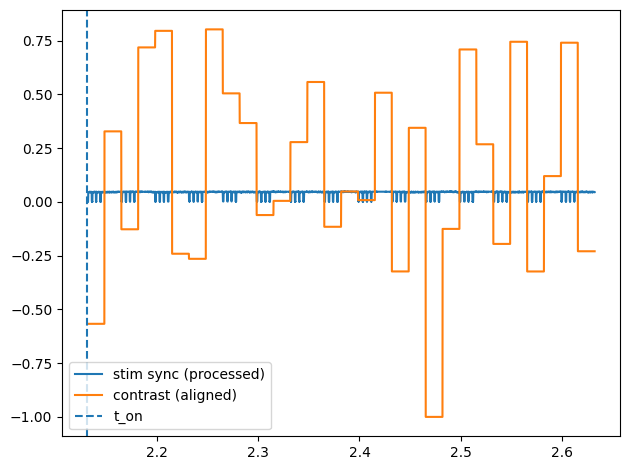

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# pick a short window right after onset
t0 = n.t_on + 0.0
t1 = n.t_on + 0.5

i0 = int(np.searchsorted(n.time_vec, t0))
i1 = int(np.searchsorted(n.time_vec, t1))

plt.figure()
plt.plot(n.time_vec[i0:i1], n.stim_ch[i0:i1], label="stim sync (processed)")
plt.plot(n.time_vec[i0:i1], n.C_20k[i0:i1], label="contrast (aligned)")
plt.axvline(n.t_on, linestyle="--", label="t_on")
plt.legend()
plt.tight_layout()
plt.show()



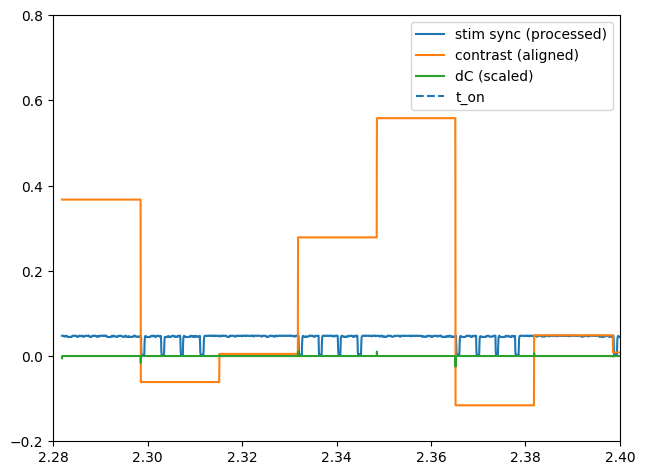

In [5]:
import numpy as np
import matplotlib.pyplot as plt

t0 = n.t_on + 0.15
t1 = n.t_on + 0.35
i0 = int(np.searchsorted(n.time_vec, t0))
i1 = int(np.searchsorted(n.time_vec, t1))

dc = np.diff(n.C_20k, prepend=n.C_20k[0])

plt.figure()
plt.plot(n.time_vec[i0:i1], n.stim_ch[i0:i1], label="stim sync (processed)")
plt.plot(n.time_vec[i0:i1], n.C_20k[i0:i1], label="contrast (aligned)")
plt.plot(n.time_vec[i0:i1], dc[i0:i1] / (np.max(np.abs(dc[i0:i1])) + 1e-12) * 0.05,
         label="dC (scaled)")
plt.axvline(n.t_on, linestyle="--", label="t_on")
plt.legend()
plt.tight_layout()
plt.axis([2.28, 2.4, -0.2, 0.8])
plt.show()



In [7]:
print("t_rel_60[0] =", n.t_rel_60[0])
print("median frame dt =", np.median(np.diff(n.t_rel_60)))

# find first time contrast changes in C_20k after onset
i_on = np.searchsorted(n.time_vec, n.t_on)
dC = np.diff(n.C_20k, prepend=n.C_20k[0])
step_idx = np.where(dC != 0)[0]
step_idx = step_idx[step_idx >= i_on]

if len(step_idx):
    print("first contrast step after t_on at (ms):",
          (n.time_vec[step_idx[0]] - n.t_on)*1000)


t_rel_60[0] = 0.0
median frame dt = 0.01666666666669414
first contrast step after t_on at (ms): 0.0
